In [12]:
from torchvision import datasets, transforms
import torch
import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt

from cnn_model import CNNModel
from vit_model import ViTModel

In [13]:
# we'll see if needed
# Define transforms to preprocess the data (you can customize these as needed)
TARGET_WIDTH = 224
TARGET_HEIGHT = 224

transform = transforms.Compose([
    transforms.ToTensor(),              # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize the image
    #transforms.Pad((111, 96, 112, 96), fill=0),  # Add Padding:  Our images are 64x33 (left,right,top, bottom)
    transforms.Pad((96,80, 95, 80), fill=0) # Add padding for ViT (target is 224*224)
])

In [14]:
# Load the dataset using ImageFolder
dataset = datasets.ImageFolder(root="dataset", transform=transform)
dataset.class_to_idx

{'holo': 0, 'non-holo': 1}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label : holo


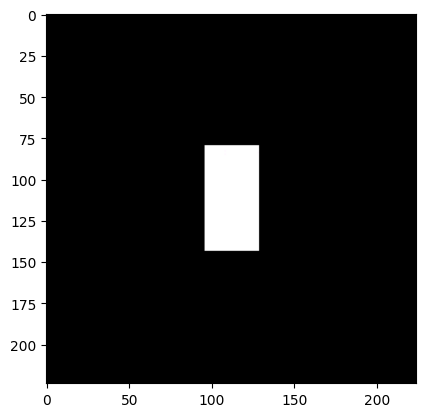

In [15]:
image_index = 943
plt.imshow(dataset[image_index][0].permute(1, 2, 0))
print(f"label : {dataset.classes[dataset[image_index][1]]}")

In [16]:
dataset[0][0]

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

In [17]:
# Use random_split to split the dataset into train, validation, and test sets
train_dataset, validation_dataset, test_dataset = random_split(dataset, [0.8, 0.1, 0.1])

In [18]:
# Define DataLoader for each split using the respective sampler
training_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True )
validation_dataloader = DataLoader(validation_dataset, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [19]:
len(train_dataset), len(validation_dataset), len(test_dataset)

(24000, 3000, 3000)

In [20]:
#model = CNNModel(num_classes=1,
#                 lr=0.0001)
model = ViTModel(num_classes=1,
                 lr=0.0001)

/home/yanis/paris_cite/S2/TER/model_training/venv/lib/python3.12/site-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name vit_tiny_patch16_224_in21k to current vit_tiny_patch16_224.augreg_in21k.
  model = create_fn(


In [21]:
model

ViTModel(
  (pretrained_ViT): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=192, out_features=576, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=192, out_features=192, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=192, out_features=768, bias=True)
          (act): GELU(approximate='non

In [22]:
checkpoint_callback = ModelCheckpoint(
        dirpath="models",
        monitor="validation_accuracy",
        filename="best",
        mode="max",
        save_last=True,
        verbose=True
    )
# train the model (hint: here are some helpful Trainer arguments for rapid idea iteration)
trainer = L.Trainer(max_epochs=30,
                    log_every_n_steps=1,
                    val_check_interval=0.25,
                    callbacks=[checkpoint_callback])

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [23]:
trainer.fit(model=model, train_dataloaders=training_dataloader, val_dataloaders=validation_dataloader)

/home/yanis/paris_cite/S2/TER/model_training/venv/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /home/yanis/paris_cite/S2/TER/model_training/models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type              | Params
------------------------------------------------------
0 | pretrained_ViT  | VisionTransformer | 5.5 M 
1 | accuracy_metric | BinaryAccuracy    | 0     
------------------------------------------------------
5.5 M     Trainable params
0         Non-trainable params
5.5 M     Total params
22.098    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/yanis/paris_cite/S2/TER/model_training/venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:492: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/home/yanis/paris_cite/S2/TER/model_training/venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/home/yanis/paris_cite/S2/TER/model_training/venv/lib/python3.12/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


/home/yanis/paris_cite/S2/TER/model_training/venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 0:  25%|██▌       | 47/188 [00:23<01:11,  1.96it/s, v_num=2, train_accuracy_step=0.461, validation_loss=0.703, validation_accuracy=0.505]

Epoch 0, global step 47: 'validation_accuracy' reached 0.50467 (best 0.50467), saving model to '/home/yanis/paris_cite/S2/TER/model_training/models/best-v1.ckpt' as top 1


Epoch 0:  50%|█████     | 94/188 [00:47<00:47,  1.97it/s, v_num=2, train_accuracy_step=0.547, validation_loss=0.642, validation_accuracy=0.616]

Epoch 0, global step 94: 'validation_accuracy' reached 0.61600 (best 0.61600), saving model to '/home/yanis/paris_cite/S2/TER/model_training/models/best-v1.ckpt' as top 1


Epoch 0:  75%|███████▌  | 141/188 [01:11<00:23,  1.96it/s, v_num=2, train_accuracy_step=0.680, validation_loss=0.612, validation_accuracy=0.648]

Epoch 0, global step 141: 'validation_accuracy' reached 0.64800 (best 0.64800), saving model to '/home/yanis/paris_cite/S2/TER/model_training/models/best-v1.ckpt' as top 1


Epoch 0: 100%|██████████| 188/188 [01:37<00:00,  1.93it/s, v_num=2, train_accuracy_step=0.750, validation_loss=0.536, validation_accuracy=0.739]

Epoch 0, global step 188: 'validation_accuracy' reached 0.73933 (best 0.73933), saving model to '/home/yanis/paris_cite/S2/TER/model_training/models/best-v1.ckpt' as top 1


Epoch 1:  25%|██▌       | 47/188 [00:22<01:06,  2.12it/s, v_num=2, train_accuracy_step=0.680, validation_loss=0.537, validation_accuracy=0.723, train_accuracy_epoch=0.608] 

Epoch 1, global step 235: 'validation_accuracy' was not in top 1


Epoch 1:  50%|█████     | 94/188 [00:45<00:45,  2.08it/s, v_num=2, train_accuracy_step=0.773, validation_loss=0.567, validation_accuracy=0.712, train_accuracy_epoch=0.608]

Epoch 1, global step 282: 'validation_accuracy' was not in top 1


Epoch 1:  75%|███████▌  | 141/188 [01:06<00:22,  2.12it/s, v_num=2, train_accuracy_step=0.742, validation_loss=0.500, validation_accuracy=0.763, train_accuracy_epoch=0.608]

Epoch 1, global step 329: 'validation_accuracy' reached 0.76333 (best 0.76333), saving model to '/home/yanis/paris_cite/S2/TER/model_training/models/best-v1.ckpt' as top 1


Epoch 1: 100%|██████████| 188/188 [01:27<00:00,  2.16it/s, v_num=2, train_accuracy_step=0.656, validation_loss=0.499, validation_accuracy=0.760, train_accuracy_epoch=0.608]

Epoch 1, global step 376: 'validation_accuracy' was not in top 1


Epoch 2:  25%|██▌       | 47/188 [00:22<01:06,  2.13it/s, v_num=2, train_accuracy_step=0.773, validation_loss=0.541, validation_accuracy=0.740, train_accuracy_epoch=0.749] 

Epoch 2, global step 423: 'validation_accuracy' was not in top 1


Epoch 2:  50%|█████     | 94/188 [00:43<00:43,  2.14it/s, v_num=2, train_accuracy_step=0.797, validation_loss=0.492, validation_accuracy=0.771, train_accuracy_epoch=0.749]

Epoch 2, global step 470: 'validation_accuracy' reached 0.77100 (best 0.77100), saving model to '/home/yanis/paris_cite/S2/TER/model_training/models/best-v1.ckpt' as top 1


Epoch 2:  75%|███████▌  | 141/188 [01:07<00:22,  2.08it/s, v_num=2, train_accuracy_step=0.781, validation_loss=0.525, validation_accuracy=0.745, train_accuracy_epoch=0.749]

Epoch 2, global step 517: 'validation_accuracy' was not in top 1


Epoch 2: 100%|██████████| 188/188 [01:31<00:00,  2.05it/s, v_num=2, train_accuracy_step=0.812, validation_loss=0.597, validation_accuracy=0.719, train_accuracy_epoch=0.749]

Epoch 2, global step 564: 'validation_accuracy' was not in top 1


Epoch 3:  25%|██▌       | 47/188 [00:20<01:02,  2.24it/s, v_num=2, train_accuracy_step=0.836, validation_loss=0.508, validation_accuracy=0.762, train_accuracy_epoch=0.790] 

Epoch 3, global step 611: 'validation_accuracy' was not in top 1


Epoch 3:  50%|█████     | 94/188 [00:42<00:42,  2.21it/s, v_num=2, train_accuracy_step=0.812, validation_loss=0.517, validation_accuracy=0.760, train_accuracy_epoch=0.790]

Epoch 3, global step 658: 'validation_accuracy' was not in top 1


Epoch 3:  75%|███████▌  | 141/188 [01:03<00:21,  2.23it/s, v_num=2, train_accuracy_step=0.773, validation_loss=0.503, validation_accuracy=0.775, train_accuracy_epoch=0.790]

Epoch 3, global step 705: 'validation_accuracy' reached 0.77500 (best 0.77500), saving model to '/home/yanis/paris_cite/S2/TER/model_training/models/best-v1.ckpt' as top 1


Epoch 3: 100%|██████████| 188/188 [01:24<00:00,  2.23it/s, v_num=2, train_accuracy_step=0.797, validation_loss=0.495, validation_accuracy=0.766, train_accuracy_epoch=0.790]

Epoch 3, global step 752: 'validation_accuracy' was not in top 1


Epoch 4:  25%|██▌       | 47/188 [00:21<01:03,  2.23it/s, v_num=2, train_accuracy_step=0.797, validation_loss=0.512, validation_accuracy=0.763, train_accuracy_epoch=0.818] 

Epoch 4, global step 799: 'validation_accuracy' was not in top 1


Epoch 4:  50%|█████     | 94/188 [00:41<00:41,  2.25it/s, v_num=2, train_accuracy_step=0.891, validation_loss=0.501, validation_accuracy=0.775, train_accuracy_epoch=0.818]

Epoch 4, global step 846: 'validation_accuracy' reached 0.77533 (best 0.77533), saving model to '/home/yanis/paris_cite/S2/TER/model_training/models/best-v1.ckpt' as top 1


Epoch 4:  75%|███████▌  | 141/188 [01:02<00:20,  2.24it/s, v_num=2, train_accuracy_step=0.859, validation_loss=0.528, validation_accuracy=0.759, train_accuracy_epoch=0.818]

Epoch 4, global step 893: 'validation_accuracy' was not in top 1


Epoch 4: 100%|██████████| 188/188 [01:23<00:00,  2.24it/s, v_num=2, train_accuracy_step=0.828, validation_loss=0.480, validation_accuracy=0.782, train_accuracy_epoch=0.818]

Epoch 4, global step 940: 'validation_accuracy' reached 0.78167 (best 0.78167), saving model to '/home/yanis/paris_cite/S2/TER/model_training/models/best-v1.ckpt' as top 1


Epoch 5:  25%|██▌       | 47/188 [00:20<01:02,  2.25it/s, v_num=2, train_accuracy_step=0.875, validation_loss=0.560, validation_accuracy=0.770, train_accuracy_epoch=0.840] 

Epoch 5, global step 987: 'validation_accuracy' was not in top 1


Epoch 5:  50%|█████     | 94/188 [00:41<00:41,  2.25it/s, v_num=2, train_accuracy_step=0.867, validation_loss=0.542, validation_accuracy=0.775, train_accuracy_epoch=0.840]

Epoch 5, global step 1034: 'validation_accuracy' was not in top 1


Epoch 5:  75%|███████▌  | 141/188 [01:03<00:21,  2.21it/s, v_num=2, train_accuracy_step=0.859, validation_loss=0.514, validation_accuracy=0.781, train_accuracy_epoch=0.840]

Epoch 5, global step 1081: 'validation_accuracy' was not in top 1


Epoch 5: 100%|██████████| 188/188 [01:24<00:00,  2.24it/s, v_num=2, train_accuracy_step=0.828, validation_loss=0.505, validation_accuracy=0.770, train_accuracy_epoch=0.840]

Epoch 5, global step 1128: 'validation_accuracy' was not in top 1


Epoch 6:  25%|██▌       | 47/188 [00:20<01:01,  2.28it/s, v_num=2, train_accuracy_step=0.852, validation_loss=0.514, validation_accuracy=0.774, train_accuracy_epoch=0.864] 

Epoch 6, global step 1175: 'validation_accuracy' was not in top 1


Epoch 6:  50%|█████     | 94/188 [00:41<00:41,  2.27it/s, v_num=2, train_accuracy_step=0.930, validation_loss=0.566, validation_accuracy=0.770, train_accuracy_epoch=0.864]

Epoch 6, global step 1222: 'validation_accuracy' was not in top 1


Epoch 6:  75%|███████▌  | 141/188 [01:02<00:20,  2.26it/s, v_num=2, train_accuracy_step=0.891, validation_loss=0.537, validation_accuracy=0.777, train_accuracy_epoch=0.864]

Epoch 6, global step 1269: 'validation_accuracy' was not in top 1


Epoch 6: 100%|██████████| 188/188 [01:23<00:00,  2.26it/s, v_num=2, train_accuracy_step=0.969, validation_loss=0.582, validation_accuracy=0.763, train_accuracy_epoch=0.864]

Epoch 6, global step 1316: 'validation_accuracy' was not in top 1


Epoch 7:  25%|██▌       | 47/188 [00:20<01:02,  2.26it/s, v_num=2, train_accuracy_step=0.953, validation_loss=0.603, validation_accuracy=0.760, train_accuracy_epoch=0.885] 

Epoch 7, global step 1363: 'validation_accuracy' was not in top 1


Epoch 7:  50%|█████     | 94/188 [00:42<00:42,  2.24it/s, v_num=2, train_accuracy_step=0.938, validation_loss=0.683, validation_accuracy=0.765, train_accuracy_epoch=0.885]

Epoch 7, global step 1410: 'validation_accuracy' was not in top 1


Epoch 7:  75%|███████▌  | 141/188 [01:03<00:21,  2.24it/s, v_num=2, train_accuracy_step=0.906, validation_loss=0.599, validation_accuracy=0.779, train_accuracy_epoch=0.885]

Epoch 7, global step 1457: 'validation_accuracy' was not in top 1


Epoch 7: 100%|██████████| 188/188 [01:24<00:00,  2.22it/s, v_num=2, train_accuracy_step=0.906, validation_loss=0.557, validation_accuracy=0.771, train_accuracy_epoch=0.885]

Epoch 7, global step 1504: 'validation_accuracy' was not in top 1


Epoch 8:  25%|██▌       | 47/188 [00:21<01:04,  2.19it/s, v_num=2, train_accuracy_step=0.945, validation_loss=0.738, validation_accuracy=0.778, train_accuracy_epoch=0.900] 

Epoch 8, global step 1551: 'validation_accuracy' was not in top 1


Epoch 8:  50%|█████     | 94/188 [00:42<00:42,  2.19it/s, v_num=2, train_accuracy_step=0.938, validation_loss=0.624, validation_accuracy=0.769, train_accuracy_epoch=0.900]

Epoch 8, global step 1598: 'validation_accuracy' was not in top 1


Epoch 8:  75%|███████▌  | 141/188 [01:04<00:21,  2.20it/s, v_num=2, train_accuracy_step=0.898, validation_loss=0.679, validation_accuracy=0.779, train_accuracy_epoch=0.900]

Epoch 8, global step 1645: 'validation_accuracy' was not in top 1


Epoch 8: 100%|██████████| 188/188 [01:25<00:00,  2.21it/s, v_num=2, train_accuracy_step=0.891, validation_loss=0.580, validation_accuracy=0.774, train_accuracy_epoch=0.900]

Epoch 8, global step 1692: 'validation_accuracy' was not in top 1


Epoch 9:  25%|██▌       | 47/188 [00:21<01:03,  2.21it/s, v_num=2, train_accuracy_step=0.945, validation_loss=0.667, validation_accuracy=0.761, train_accuracy_epoch=0.913] 

Epoch 9, global step 1739: 'validation_accuracy' was not in top 1


Epoch 9:  50%|█████     | 94/188 [00:43<00:43,  2.18it/s, v_num=2, train_accuracy_step=0.961, validation_loss=0.753, validation_accuracy=0.777, train_accuracy_epoch=0.913]

Epoch 9, global step 1786: 'validation_accuracy' was not in top 1


Epoch 9:  75%|███████▌  | 141/188 [01:03<00:21,  2.22it/s, v_num=2, train_accuracy_step=0.945, validation_loss=0.688, validation_accuracy=0.773, train_accuracy_epoch=0.913]

Epoch 9, global step 1833: 'validation_accuracy' was not in top 1


Epoch 9: 100%|██████████| 188/188 [01:24<00:00,  2.23it/s, v_num=2, train_accuracy_step=0.938, validation_loss=0.664, validation_accuracy=0.773, train_accuracy_epoch=0.913]

Epoch 9, global step 1880: 'validation_accuracy' was not in top 1


Epoch 10:  25%|██▌       | 47/188 [00:20<01:02,  2.27it/s, v_num=2, train_accuracy_step=0.906, validation_loss=0.686, validation_accuracy=0.779, train_accuracy_epoch=0.931]

Epoch 10, global step 1927: 'validation_accuracy' was not in top 1


Epoch 10:  50%|█████     | 94/188 [00:41<00:41,  2.29it/s, v_num=2, train_accuracy_step=0.891, validation_loss=0.742, validation_accuracy=0.770, train_accuracy_epoch=0.931]

Epoch 10, global step 1974: 'validation_accuracy' was not in top 1


Epoch 10:  75%|███████▌  | 141/188 [01:02<00:20,  2.26it/s, v_num=2, train_accuracy_step=0.984, validation_loss=0.834, validation_accuracy=0.778, train_accuracy_epoch=0.931]

Epoch 10, global step 2021: 'validation_accuracy' was not in top 1


Epoch 10:  88%|████████▊ | 165/188 [01:11<00:09,  2.32it/s, v_num=2, train_accuracy_step=0.938, validation_loss=0.834, validation_accuracy=0.778, train_accuracy_epoch=0.931]

/home/yanis/paris_cite/S2/TER/model_training/venv/lib/python3.12/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [ ]:
#print(f"Loading model best.ckpt")
#best_model = CNNModel.load_from_checkpoint("models/best.ckpt", num_classes=1, lr=0.0001).to('cuda')
#best_model

In [24]:
print(f"Loading model best.ckpt")
best_model = ViTModel.load_from_checkpoint("models/best-v1.ckpt", num_classes=1, lr=0.0001).to('cuda')
best_model

Loading model best.ckpt


/home/yanis/paris_cite/S2/TER/model_training/venv/lib/python3.12/site-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name vit_tiny_patch16_224_in21k to current vit_tiny_patch16_224.augreg_in21k.
  model = create_fn(


ViTModel(
  (pretrained_ViT): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=192, out_features=576, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=192, out_features=192, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=192, out_features=768, bias=True)
          (act): GELU(approximate='non

In [25]:
input, label = next(iter(test_dataloader))

In [26]:
input = input.to('cuda')
input.shape

torch.Size([128, 3, 224, 224])

In [27]:
label = label.to('cuda')
label.shape

torch.Size([128])

In [28]:
# For every INPUT_SIZE / Prediction size do the prediction then append
best_model.eval()
with torch.no_grad():
        #input = input.unsqueeze(0).to('cpu')
        #print(input)
        y_hat = best_model(input).squeeze()
        result = torch.nn.functional.sigmoid(y_hat)
# Output the last 100 of the result

In [29]:
result

tensor([0.9351, 0.9714, 0.3627, 0.1418, 0.5261, 0.9647, 0.6980, 0.4075, 0.7207,
        0.5179, 0.0435, 0.5058, 0.0073, 0.9472, 0.8690, 0.5513, 0.9751, 0.9591,
        0.6555, 0.8751, 0.8892, 0.6918, 0.4900, 0.0498, 0.7538, 0.9683, 0.6867,
        0.9061, 0.9249, 0.9157, 0.1855, 0.7719, 0.9694, 0.7420, 0.9255, 0.0397,
        0.7750, 0.8253, 0.6235, 0.6668, 0.6615, 0.2057, 0.2617, 0.0080, 0.8687,
        0.9533, 0.3209, 0.0161, 0.0356, 0.0656, 0.9721, 0.9669, 0.2779, 0.8716,
        0.9646, 0.3607, 0.9113, 0.9637, 0.9039, 0.7049, 0.5602, 0.6361, 0.0273,
        0.9400, 0.2535, 0.7930, 0.0390, 0.8970, 0.9526, 0.9416, 0.4072, 0.0072,
        0.0093, 0.3741, 0.9503, 0.3566, 0.8670, 0.3487, 0.1036, 0.4163, 0.9888,
        0.9069, 0.7401, 0.0678, 0.9539, 0.4978, 0.8160, 0.9348, 0.8016, 0.9649,
        0.9311, 0.2102, 0.9488, 0.0719, 0.9170, 0.8647, 0.8692, 0.5067, 0.3115,
        0.0758, 0.9592, 0.4297, 0.9075, 0.0162, 0.2135, 0.7954, 0.1990, 0.0786,
        0.0626, 0.7620, 0.0085, 0.0726, 

In [30]:
label

tensor([1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0,
        1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0,
        0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0,
        0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1,
        1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1,
        1, 0, 0, 1, 0, 1, 1, 0], device='cuda:0')